In [ ]:
!pip install ExKMC

     |████████████████████████████████| 139 kB 5.3 MB/s 
  Created wheel for ExKMC: filename=ExKMC-0.0.3-cp37-cp37m-linux_x86_64.whl size=277378 sha256=c2d520ea6a6aa3945b9492fd846fd670561376242af4c70423cfe9cf0d1399a0
  Stored in directory: /root/.cache/pip/wheels/5d/65/9c/d88f7f6d8358ba43f0b252fb5d244cf999b5487893d864b8d4
Successfully built ExKMC


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def calc_cost(tree, k, x_data):
    clusters = tree.predict(x_data)
    cost = 0
    for c in range(k):
        cluster_data = x_data[clusters == c]
        if cluster_data.shape[0] > 0:
            center = cluster_data.mean(axis=0)
            for x in cluster_data:
                cost += np.linalg.norm(x - center) ** 2
    return cost

def plot_kmeans(kmeans, x_data):
    cmap = plt.cm.get_cmap('PuBuGn')

    k = kmeans.n_clusters
    x_min, x_max = x_data[:, 0].min() - 1, x_data[:, 0].max() + 1
    y_min, y_max = x_data[:, 1].min() - 1, x_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                         np.arange(y_min, y_max, .1))

    values = np.c_[xx.ravel(), yy.ravel()]

    ########### K-MEANS Clustering ###########
    plt.figure(figsize=(4, 4))
    Z = kmeans.predict(values)
    Z = Z.reshape(xx.shape)
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=cmap,
               aspect='auto', origin='lower', alpha=0.4)

    y_kmeans = kmeans.predict(x_data)
    plt.scatter([x[0] for x in x_data], [x[1] for x in x_data], c=y_kmeans, s=20, edgecolors='black', cmap=cmap)
    for c in range(k):
        center = x_data[y_kmeans == c].mean(axis=0)
        plt.scatter([center[0]], [center[1]], c="white", marker='$%s$' % c, s=350, linewidths=.5, zorder=10,
                    edgecolors='black')

    plt.xticks([])
    plt.yticks([])
    plt.title("Near Optimal Baseline", fontsize=14)
    plt.show()
    
    
def plot_tree_boundary(cluster_tree, k, x_data, kmeans, plot_mistakes=False):
    cmap = plt.cm.get_cmap('PuBuGn')
    
    ########### IMM leaves ###########
    plt.figure(figsize=(4, 4))
    
    x_min, x_max = x_data[:, 0].min() - 1, x_data[:, 0].max() + 1
    y_min, y_max = x_data[:, 1].min() - 1, x_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                         np.arange(y_min, y_max, .1))

    values = np.c_[xx.ravel(), yy.ravel()]
    
    y_cluster_tree = cluster_tree.predict(x_data)

    Z = cluster_tree.predict(values)
    Z = Z.reshape(xx.shape)
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=cmap, 
               aspect='auto', origin='lower', alpha=0.4)


    plt.scatter([x[0] for x in x_data], [x[1] for x in x_data], c=y_cluster_tree, edgecolors='black', s=20, cmap=cmap)
    for c in range(k):
        center = x_data[y_cluster_tree==c].mean(axis=0)
        plt.scatter([center[0]], [center[1]], c="white", marker='$%s$' % c, s=350, linewidths=.5, zorder=10, edgecolors='black')
        
    if plot_mistakes:
        y = kmeans.predict(x_data)
        mistakes = x_data[y_cluster_tree != y]
        plt.scatter([x[0] for x in mistakes], [x[1] for x in mistakes], marker='x', c='red', s=60, edgecolors='black', cmap=cmap)

    plt.xticks([])
    plt.yticks([])
    plt.title("Approximation Ratio: %.2f" % (cluster_tree.score(x_data) / -kmeans.score(x_data)), fontsize=14)
    plt.show()
    

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=np.array(['Cluster %d' % i for i in range(len(classes))]), 
           yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Cluster label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plot_df(df, dataset, step=1, ylim=None):
    k = int(df.iloc[0].leaves)
    cols = ["CART", "KDTree", "ExKMC", "ExKMC (base: IMM)"]

    flatui = ["#3498db", "#e74c3c", "#2ecc71", "#34495e"]
    palette = sns.color_palette(flatui)

    plt.figure(figsize=(4,3))
    ax = sns.lineplot(data=df[::step][cols], linewidth=4, palette=palette, markers=True,
                      dashes=False)
    plt.yticks(fontsize=14)

    plt.xticks(np.arange(0, 1.01, 1/3) * (df.shape[0] - 1), ['$k$\n$(=%s)$' % k, 
                                                             r'$2 \cdot k$', 
                                                             r'$3 \cdot k$', 
                                                             '$4 \cdot k$\n$(=%s)$' % (4*k)], 
               fontsize=14)
    
    if ylim is not None:
        axes = plt.gca()
        axes.set_ylim(ylim)

    plt.title(dataset, fontsize=22)
    plt.xlabel("# Leaves", fontsize=18)
    ax.xaxis.set_label_coords(0.5, -0.15)
    plt.ylabel("Cost Ratio", fontsize=18)
    plt.legend(fontsize=12)
    plt.show()

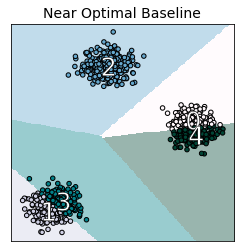

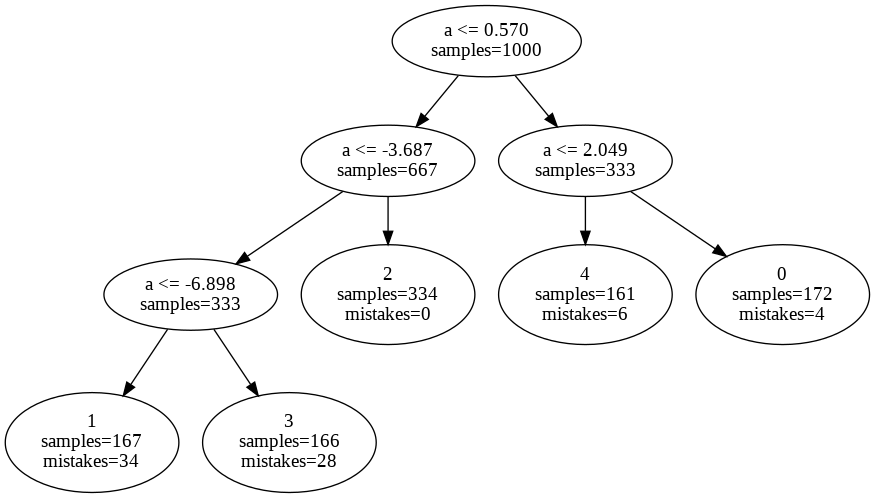

In [ ]:
%matplotlib inline
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from ExKMC.Tree import Tree
from IPython.display import Image
#from utils import calc_cost, plot_kmeans, plot_tree_boundary
n = 1000
d = 2
k = 5
x_data, _ = make_blobs(n, d, random_state=42)

kmeans = KMeans(k, random_state=42)
kmeans.fit(x_data)

plot_kmeans(kmeans, x_data)

tree = Tree(k)
tree.fit(x_data, kmeans)
tree.plot(filename="test", feature_names=["a" for  i in range(k)])
Image(filename='test.gv.png')